In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

### 50

In [2]:
newsdf=pd.read_csv("src/newsCorpora.csv",header=None,sep="\t", names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
newsdf=newsdf[newsdf.PUBLISHER.isin(["Reuters","Huffington Post","Businessweek","Contactmusic.com","Daily Mail"])][["CATEGORY","TITLE"]]
train,test=train_test_split(newsdf,test_size=0.2,stratify=newsdf.CATEGORY)
valid,test=train_test_split(test,test_size=0.5,stratify=test.CATEGORY)
train.to_csv('src/train.txt', index=False, sep="\t",header=None)
valid.to_csv('src/valid.txt', index=False, sep="\t",header=None)
test.to_csv('src/test.txt', index=False, sep="\t",header=None)

In [10]:
newsdf.groupby("CATEGORY").count()

,TITLE
CATEGORY,
b,5627
e,5279
m,910
t,1524


In [11]:
newsdf.CATEGORY.value_counts()

b    5627
e    5279
t    1524
m     910
Name: CATEGORY, dtype: int64

### 51

TF-IDFというのがあるらしい  
nltkを使うやつ：時間かかりすぎるので断念

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import re

In [3]:
def normalizeText(text):
    text = text.lower()  # 小文字化
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = re.sub('[0-9|,|.]+', '0', text)
    text = text.translate(table)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"^ | $", "", text)
    return text

In [192]:
Tfidfvec = TfidfVectorizer(min_df=5, max_df=0.9)#,max_features=1000, ngram_range=(1, 2))

train_vec=Tfidfvec.fit_transform(train.TITLE.map(lambda x: normalizeText(x)))
valid_vec=Tfidfvec.transform(valid.TITLE.map(lambda x: normalizeText(x)))
test_vec=Tfidfvec.transform(test.TITLE.map(lambda x: normalizeText(x)))

train_feature=pd.DataFrame(train_vec.toarray(), columns=Tfidfvec.get_feature_names())
valid_feature=pd.DataFrame(valid_vec.toarray(), columns=Tfidfvec.get_feature_names())
test_feature=pd.DataFrame(test_vec.toarray(), columns=Tfidfvec.get_feature_names())

# train_feature.to_csv("src/train.feature.txt", index=False, sep="\t")
# valid_feature.to_csv("src/valid.feature.txt", index=False, sep="\t")
# test_feature.to_csv("src/test.feature.txt", index=False, sep="\t")
# train_feature=pd.read_csv("src/train.feature.txt",sep="\t")
# valid_feature=pd.read_csv("src/valid.feature.txt",sep="\t")
# test_feature=pd.read_csv("src/test.feature.txt",sep="\t")

### 52

In [12]:
from sklearn.linear_model import LogisticRegression

In [115]:
clf_Log = LogisticRegression( max_iter=10000)
clf_Log.fit(train_feature, train['CATEGORY'])

LogisticRegression(max_iter=10000)

### 53

In [5]:
import numpy as np

In [116]:
train_res=pd.DataFrame(np.array([np.max(clf_Log.predict_proba(train_feature),axis=1),clf_Log.predict(train_feature)]).T,columns=["predict_prob","predict_category"])
test_res=pd.DataFrame(np.array([np.max(clf_Log.predict_proba(test_feature),axis=1),clf_Log.predict(test_feature)]).T,columns=["predict_prob","predict_category"])

### 54

In [52]:
#カットなし
print(clf_Log.score(train_feature,train.CATEGORY))
print(clf_Log.score(test_feature,test.CATEGORY))

0.9418103448275862
0.8905547226386806


In [65]:
#10以下カット
print(clf_Log.score(train_feature,train.CATEGORY))
print(clf_Log.score(test_feature,test.CATEGORY))

0.9173538230884558
0.8860569715142429


In [56]:
#n2gramも含めたけど…
print(clf_Log.score(train_feature,train.CATEGORY))
print(clf_Log.score(test_feature,test.CATEGORY))

0.9421851574212894
0.8740629685157422


In [69]:
#n2 10以下カット
print(clf_Log.score(train_feature,train.CATEGORY))
print(clf_Log.score(test_feature,test.CATEGORY))

0.9196026986506747
0.8883058470764618


In [117]:
#n2 5以下カット
print(clf_Log.score(train_feature,train.CATEGORY))
print(clf_Log.score(test_feature,test.CATEGORY))

0.9418103448275862
0.8905547226386806


### 55

In [6]:
from sklearn.metrics import confusion_matrix

In [7]:
train_true=train.CATEGORY
train_pred=clf_Log.predict(train_feature)
test_true=test.CATEGORY
test_pred=clf_Log.predict(test_feature)

NameError: name 'clf_Log' is not defined

In [98]:
#train confusion
confusion_matrix(train_true, train_pred)

array([[4360,   78,    7,   57],
       [  33, 4181,    1,    8],
       [  84,  133,  504,    7],
       [ 177,  119,    3,  920]])

In [99]:
#test confusion
confusion_matrix(test_true, test_pred)

array([[538,  18,   1,   6],
       [ 18, 508,   0,   2],
       [ 14,  21,  53,   3],
       [ 35,  25,   2,  90]])

### 56

In [107]:
from sklearn.metrics import classification_report

In [110]:
#train
print(classification_report(train_true, train_pred))

              precision    recall  f1-score   support

           b       0.94      0.97      0.95      4502
           e       0.93      0.99      0.96      4223
           m       0.98      0.69      0.81       728
           t       0.93      0.75      0.83      1219

    accuracy                           0.93     10672
   macro avg       0.94      0.85      0.89     10672
weighted avg       0.93      0.93      0.93     10672



In [111]:
#test
print(classification_report(test_true, test_pred))

              precision    recall  f1-score   support

           b       0.89      0.96      0.92       563
           e       0.89      0.96      0.92       528
           m       0.95      0.58      0.72        91
           t       0.89      0.59      0.71       152

    accuracy                           0.89      1334
   macro avg       0.90      0.77      0.82      1334
weighted avg       0.89      0.89      0.88      1334



In [ ]:
#recallが低い：あるカテゴリーをそのカテゴリーだと識別できた割合が低い

### 57

In [148]:
coefs=pd.DataFrame(clf_Log.coef_.T,columns=clf_Log.classes_)
coefs["terms"]=Tfidfvec.get_feature_names()

In [170]:
category={"b":"business","t":"science and technology","e":"entertainment","m":"health"}
for i in clf_Log.classes_:
    print(category[i])
    print("top  :","\t".join(coefs.sort_values(i,ascending=False)[:10]["terms"].values))
    print("worst:","\t".join(coefs.sort_values(i,ascending=True)[:10]["terms"].values))

business
top  : china	fed	bank	stocks	ecb	euro	update	ukraine	oil	dollar
worst: and	the	ebola	her	she	google	facebook	apple	video	study
entertainment
top  : kardashian	chris	kim	star	miley	her	cyrus	paul	she	movie
worst: update	us	google	says	china	facebook	study	ceo	gm	apple
health
top  : ebola	cancer	study	fda	drug	mers	health	cigarettes	cdc	could
worst: gm	facebook	google	apple	ceo	fed	climate	twitter	deal	bank
science and technology
top  : google	facebook	apple	microsoft	climate	tesla	gm	nasa	fcc	samsung
worst: stocks	fed	percent	american	drug	her	cancer	ecb	kardashian	shares


### 58

In [9]:
Tfidfvec = TfidfVectorizer(min_df=10, max_df=0.8)#,max_features=1000, ngram_range=(1, 2))

train_vec=Tfidfvec.fit_transform(train.TITLE.map(lambda x: normalizeText(x)))
valid_vec=Tfidfvec.transform(valid.TITLE.map(lambda x: normalizeText(x)))
test_vec=Tfidfvec.transform(test.TITLE.map(lambda x: normalizeText(x)))

train_feature=pd.DataFrame(train_vec.toarray(), columns=Tfidfvec.get_feature_names())
valid_feature=pd.DataFrame(valid_vec.toarray(), columns=Tfidfvec.get_feature_names())
test_feature=pd.DataFrame(test_vec.toarray(), columns=Tfidfvec.get_feature_names())

In [8]:
train_true=train.CATEGORY
valid_true=valid.CATEGORY
test_true=test.CATEGORY

In [201]:
from tqdm import tqdm
import matplotlib.pyplot as plt

In [211]:
scores=[]
for C in tqdm(np.logspace(-3, 4, 8, base=10)):
    clf_Log = LogisticRegression(max_iter=10000, C=C)
    clf_Log.fit(train_feature, train_true)
    train_score=clf_Log.score(train_feature, train_true)
    valid_score=clf_Log.score(valid_feature, valid_true)
    test_score=clf_Log.score(test_feature, test_true)
    scores.append([train_score,valid_score,test_score])
scores=np.array(scores).T

100%|██████████| 8/8 [07:23<00:00, 55.42s/it]


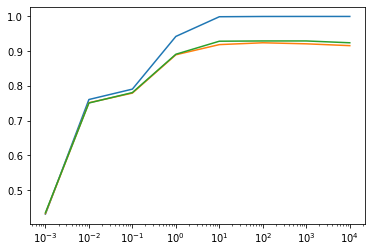

In [212]:
cs=np.logspace(-3, 4, 8, base=10)
plt.plot(cs,scores[0],label="train")
plt.plot(cs,scores[1],label="valid")
plt.plot(cs,scores[2],label="test")
plt.xscale("log")

過学習がちょい見える

### 59

実行時間長すぎて断念  
一応動くコード…

In [19]:
import optuna

In [15]:
from sklearn.metrics import f1_score

In [28]:
clf_Log = LogisticRegression(C=10.0, max_iter=10000)
clf_Log.fit(train_feature, train_true)
train_pred=clf_Log.predict(train_feature)

In [20]:
def objective(trial):
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    C = trial.suggest_loguniform('C', 1e-4, 1e4)
    clf_Log=LogisticRegression(max_iter=10000,penalty="elasticnet",solver='saga', l1_ratio=l1_ratio,C=C)
    clf_Log.fit(train_feature, train_true)
    valid_pred=clf_Log.predict(valid_feature)
    return f1_score(valid_pred, valid_true, average='micro')

In [22]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=1000,n_trials=100)

[I 2020-08-24 18:06:07,222] Trial 0 finished with value: 0.8808095952023988 and parameters: {'l1_ratio': 0.6575925074474871, 'C': 3.1044375292893234}. Best is trial 0 with value: 0.8808095952023988.
/home/yumizsui/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[I 2020-08-24 18:10:26,797] Trial 1 finished with value: 0.8515742128935532 and parameters: {'l1_ratio': 0.7603975372415486, 'C': 1955.918787281466}. Best is trial 0 with value: 0.8808095952023988.


In [26]:
params=study.best_trial.params
clf_Log=LogisticRegression(max_iter=10000,penalty="elasticnet",solver='saga', l1_ratio=params["l1_ratio"],C=params["C"])
clf_Log.fit(train_feature, train_true)b

LogisticRegression(C=3.1044375292893234, l1_ratio=0.6575925074474871,
                   max_iter=10000, penalty='elasticnet', solver='saga')

In [28]:
train_pred=clf_Log.predict(train_feature)
valid_pred=clf_Log.predict(valid_feature)
test_pred=clf_Log.predict(test_feature)

print("train : ",f1_score(train_pred, train_true, average='micro'))
print("valid : ",f1_score(valid_pred, valid_true, average='micro'))
print("test  : ",f1_score(test_pred, test_true, average='micro'))

train :  0.9450899550224887
valid :  0.8808095952023988
test  :  0.8703148425787106
